# Cargo Holds:  Clean or Dirty?
___

### Modeling

For this problem, a binary image classification, we have reviewed, explored and structed the data to be classified using a Convolutional Neural Network model.  The architecture of CNNs are particularly well suited for this problem.  By using filters to scan sections of the image, the model learns features, edges and other patterns.  The model can combine these features to dectect the underlying content in the image.  Since they scan the whole image, the orientation of the image has less importance, which in this case is helpful with a small, imbalanced dataset of images of objects that occupy the entirety of the image.  The model uses different layers to determine different features of the image.  For the small dataset of images of large portions, we don't necessarily need a deep model to detect additional objects (cars, faces, animals, etc).  This model is also known to scale well to big data.  At this point that is not a concern, but as previously mentioned, this dataset has the potential for robust growth.

Now that synthetic data has been created to balance and augment the size of the dataset, the model can be constructed and fit. The dataset is still small, so to increase the size of the training set, the training data will be augmented on the fly during training using tensorflow ImageDataGenerator. The augmentations there will be kept modest as a significant portion of the data (27%) was asyntehtically generated. The validation set will not be augmented to simulate closer to reality model performance.

Additionally the model will be regularized and normalized (rescaling, dropout, batchnormalization, l2, learning rate, and early stopping).  The model encorporates checkpoints as well to preserve the entire model as it passes through accuracy and recall thresholds.  We have added several performance metrics to monitor during fitting.

We will start by constructing the image generator to augment the training data on the fly as it is fed to the model (not saved down to avoid storage and improve performance).  Then the model will be constructed and compiled before reviewing the architecture.  The model, while initially starting with 32 filters, also performed the best with a simpler architecture.
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, smart_resize

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

In [2]:
# create the image data generator to apply the transformations to data
# the transformations are realistic as it relates to what could be seen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.8, 1.2),
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

validate_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Loading in image data
model_target_size = (224, 224)
model_batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '../data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

validation_generator = validate_datagen.flow_from_directory(
    '../data/validate/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

Found 1040 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [3]:
# model for image classification
model = Sequential()
model.add(Input((224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy', 'AUC', Precision(), Recall()])

# architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 64)                2

In [5]:
# add callbacks
checkpoint_path='../assets/saved_models/'
checkpoint_accuracy = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False)
checkpoint_recall = ModelCheckpoint(checkpoint_path + 'best_recall_model', monitor='val_recall', save_best_only=True, verbose=1, \
                                    save_weights_only=False, mode='max')
earlystopping = EarlyStopping(restore_best_weights=True, monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

# fit model
history = model.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[earlystopping, checkpoint_accuracy, checkpoint_recall])

Epoch 1/25
33/33 [==============================] - ETA: 0s - loss: 1.1503 - accuracy: 0.6010 - auc: 0.6081 - precision: 0.5985 - recall: 0.6135
Epoch 1: val_accuracy improved from -inf to 0.55455, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 1: val_recall improved from -inf to 0.14545, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 132s 4s/step - loss: 1.1503 - accuracy: 0.6010 - auc: 0.6081 - precision: 0.5985 - recall: 0.6135 - val_loss: 0.6656 - val_accuracy: 0.5545 - val_auc: 0.7031 - val_precision: 0.8000 - val_recall: 0.1455
Epoch 2/25
33/33 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.6260 - auc: 0.6744 - precision: 0.6123 - recall: 0.6865
Epoch 2: val_accuracy improved from 0.55455 to 0.59091, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 2: val_recall improved from 0.14545 to 0.29091, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 127s 4s/step - loss: 0.7065 - accuracy: 0.6260 - auc: 0.6744 - precision: 0.6123 - recall: 0.6865 - val_loss: 0.6530 - val_accuracy: 0.5909 - val_auc: 0.7339 - val_precision: 0.7273 - val_recall: 0.2909
Epoch 3/25
33/33 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.6712 - auc: 0.7121 - precision: 0.6584 - recall: 0.7115
Epoch 3: val_accuracy improved from 0.59091 to 0.67273, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 3: val_recall improved from 0.29091 to 0.54545, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 127s 4s/step - loss: 0.6749 - accuracy: 0.6712 - auc: 0.7121 - precision: 0.6584 - recall: 0.7115 - val_loss: 0.6403 - val_accuracy: 0.6727 - val_auc: 0.7617 - val_precision: 0.7317 - val_recall: 0.5455
Epoch 4/25
33/33 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6981 - auc: 0.7380 - precision: 0.6807 - recall: 0.7462
Epoch 4: val_accuracy did not improve from 0.67273

Epoch 4: val_recall improved from 0.54545 to 0.60000, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 122s 4s/step - loss: 0.6483 - accuracy: 0.6981 - auc: 0.7380 - precision: 0.6807 - recall: 0.7462 - val_loss: 0.6371 - val_accuracy: 0.6545 - val_auc: 0.7582 - val_precision: 0.6735 - val_recall: 0.6000
Epoch 5/25
33/33 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.6788 - auc: 0.7398 - precision: 0.6637 - recall: 0.7250
Epoch 5: val_accuracy did not improve from 0.67273

Epoch 5: val_recall improved from 0.60000 to 0.61818, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 124s 4s/step - loss: 0.6484 - accuracy: 0.6788 - auc: 0.7398 - precision: 0.6637 - recall: 0.7250 - val_loss: 0.6263 - val_accuracy: 0.6364 - val_auc: 0.7430 - val_precision: 0.6415 - val_recall: 0.6182
Epoch 6/25
33/33 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.7135 - auc: 0.7881 - precision: 0.7018 - recall: 0.7423
Epoch 6: val_accuracy improved from 0.67273 to 0.69091, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 6: val_recall improved from 0.61818 to 0.69091, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 124s 4s/step - loss: 0.5917 - accuracy: 0.7135 - auc: 0.7881 - precision: 0.7018 - recall: 0.7423 - val_loss: 0.6070 - val_accuracy: 0.6909 - val_auc: 0.7894 - val_precision: 0.6909 - val_recall: 0.6909
Epoch 7/25
33/33 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.7308 - auc: 0.7956 - precision: 0.7158 - recall: 0.7654
Epoch 7: val_accuracy did not improve from 0.69091

Epoch 7: val_recall did not improve from 0.69091
33/33 [==============================] - 117s 4s/step - loss: 0.5847 - accuracy: 0.7308 - auc: 0.7956 - precision: 0.7158 - recall: 0.7654 - val_loss: 0.5922 - val_accuracy: 0.6636 - val_auc: 0.7574 - val_precision: 0.7045 - val_recall: 0.5636
Epoch 8/25
33/33 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.7442 - auc: 0.8049 - precision: 0.7309 - recall: 0.7731
Epoch 8: val_accuracy improved from 0.69091 to 0.74545, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 8: val_recall improved from 0.69091 to 0.70909, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 133s 4s/step - loss: 0.5771 - accuracy: 0.7442 - auc: 0.8049 - precision: 0.7309 - recall: 0.7731 - val_loss: 0.5785 - val_accuracy: 0.7455 - val_auc: 0.8160 - val_precision: 0.7647 - val_recall: 0.7091
Epoch 9/25
33/33 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7250 - auc: 0.8052 - precision: 0.7135 - recall: 0.7519
Epoch 9: val_accuracy did not improve from 0.74545

Epoch 9: val_recall did not improve from 0.70909
33/33 [==============================] - 121s 4s/step - loss: 0.5574 - accuracy: 0.7250 - auc: 0.8052 - precision: 0.7135 - recall: 0.7519 - val_loss: 0.5692 - val_accuracy: 0.7182 - val_auc: 0.8150 - val_precision: 0.7400 - val_recall: 0.6727
Epoch 10/25
33/33 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7413 - auc: 0.8220 - precision: 0.7311 - recall: 0.7635
Epoch 10: val_accuracy improved from 0.74545 to 0.76364, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 10: val_recall improved from 0.70909 to 0.80000, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 126s 4s/step - loss: 0.5491 - accuracy: 0.7413 - auc: 0.8220 - precision: 0.7311 - recall: 0.7635 - val_loss: 0.5541 - val_accuracy: 0.7636 - val_auc: 0.8264 - val_precision: 0.7458 - val_recall: 0.8000
Epoch 11/25
33/33 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.7635 - auc: 0.8484 - precision: 0.7473 - recall: 0.7962
Epoch 11: val_accuracy improved from 0.76364 to 0.77273, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 11: val_recall improved from 0.80000 to 0.81818, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 127s 4s/step - loss: 0.4984 - accuracy: 0.7635 - auc: 0.8484 - precision: 0.7473 - recall: 0.7962 - val_loss: 0.5339 - val_accuracy: 0.7727 - val_auc: 0.8441 - val_precision: 0.7500 - val_recall: 0.8182
Epoch 12/25
33/33 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.7673 - auc: 0.8477 - precision: 0.7518 - recall: 0.7981
Epoch 12: val_accuracy did not improve from 0.77273

Epoch 12: val_recall did not improve from 0.81818
33/33 [==============================] - 119s 4s/step - loss: 0.4959 - accuracy: 0.7673 - auc: 0.8477 - precision: 0.7518 - recall: 0.7981 - val_loss: 0.5270 - val_accuracy: 0.7455 - val_auc: 0.8296 - val_precision: 0.7755 - val_recall: 0.6909
Epoch 13/25
33/33 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.7817 - auc: 0.8537 - precision: 0.7769 - recall: 0.7904
Epoch 13: val_accuracy did not improve from 0.77273

Epoch 13: val_recall did not improve from 0.81818
33/33 [=======

INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 14: val_recall did not improve from 0.81818
33/33 [==============================] - 121s 4s/step - loss: 0.4923 - accuracy: 0.7644 - auc: 0.8506 - precision: 0.7505 - recall: 0.7923 - val_loss: 0.5066 - val_accuracy: 0.7818 - val_auc: 0.8334 - val_precision: 0.7925 - val_recall: 0.7636
Epoch 15/25
33/33 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.7606 - auc: 0.8392 - precision: 0.7542 - recall: 0.7731
Epoch 15: val_accuracy improved from 0.78182 to 0.80909, saving model to ../assets/saved_models\


INFO:tensorflow:Assets written to: ../assets/saved_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\assets



Epoch 15: val_recall improved from 0.81818 to 0.87273, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 127s 4s/step - loss: 0.5177 - accuracy: 0.7606 - auc: 0.8392 - precision: 0.7542 - recall: 0.7731 - val_loss: 0.4798 - val_accuracy: 0.8091 - val_auc: 0.8602 - val_precision: 0.7742 - val_recall: 0.8727
Epoch 16/25
33/33 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.7779 - auc: 0.8494 - precision: 0.7651 - recall: 0.8019
Epoch 16: val_accuracy did not improve from 0.80909

Epoch 16: val_recall improved from 0.87273 to 0.90909, saving model to ../assets/saved_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 125s 4s/step - loss: 0.5064 - accuracy: 0.7779 - auc: 0.8494 - precision: 0.7651 - recall: 0.8019 - val_loss: 0.5431 - val_accuracy: 0.7000 - val_auc: 0.8407 - val_precision: 0.6410 - val_recall: 0.9091
Epoch 17/25
33/33 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.7635 - auc: 0.8467 - precision: 0.7429 - recall: 0.8058
Epoch 17: val_accuracy did not improve from 0.80909

Epoch 17: val_recall did not improve from 0.90909
33/33 [==============================] - 119s 4s/step - loss: 0.5063 - accuracy: 0.7635 - auc: 0.8467 - precision: 0.7429 - recall: 0.8058 - val_loss: 0.5162 - val_accuracy: 0.7636 - val_auc: 0.8339 - val_precision: 0.7231 - val_recall: 0.8545
Epoch 18/25
33/33 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.7654 - auc: 0.8426 - precision: 0.7546 - recall: 0.7865
Epoch 18: val_accuracy did not improve from 0.80909

Epoch 18: val_recall did not improve from 0.90909
33/33 [=======

INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models\best_recall_model\assets


33/33 [==============================] - 120s 4s/step - loss: 0.4418 - accuracy: 0.8029 - auc: 0.8828 - precision: 0.7922 - recall: 0.8212 - val_loss: 0.6041 - val_accuracy: 0.7364 - val_auc: 0.8410 - val_precision: 0.6711 - val_recall: 0.9273
Epoch 25/25
33/33 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7933 - auc: 0.8714 - precision: 0.7872 - recall: 0.8038
Epoch 25: val_accuracy did not improve from 0.80909

Epoch 25: val_recall did not improve from 0.92727
33/33 [==============================] - 118s 4s/step - loss: 0.4634 - accuracy: 0.7933 - auc: 0.8714 - precision: 0.7872 - recall: 0.8038 - val_loss: 0.5899 - val_accuracy: 0.7455 - val_auc: 0.8223 - val_precision: 0.7015 - val_recall: 0.8545


___
### Model Evaluation

The model's performance over epochs will be monitored to watch for steady improvements and avoiding oscillations that can indicate overfitting or underfitting

When happy the model is not overfitting or underfitting, the model's predictions can be evaluated on the test set.  For this problem, determining if a cargo hold is clean or dirty, the priority is to reduce false negatives, instances where the prediction that the hold is clean is wrong.  The outcome of telling a ship operator that their ship is clean when it is not, will lead to overconfidence, booking cargoes the ship might not be able to load, leading to damages in the tens or hundreds of thousands of dollars (time, cleaning materials, and labor).  False negatives are optimized when recall closes in on 1, indicating the model correctly identified all the positive instances.

Finally the model's ROC AUC score can be assessed as well as the ROC AUC curve.  This graph will help determine how well the model is at differentiating between the classes as well as providing a measure to use against other modes.  The perfect outcome is 1.00 and a curve that looks like the left side of a square.  A model with those results is perfectly distinguishing the classes.  Though, that result would likely raise more concerns.  On the other hand, a model with  ROUC AUC score of 0.5 or a curve starting at 0,0 at a 45 degree angle would mean the model can't distinguish at all.

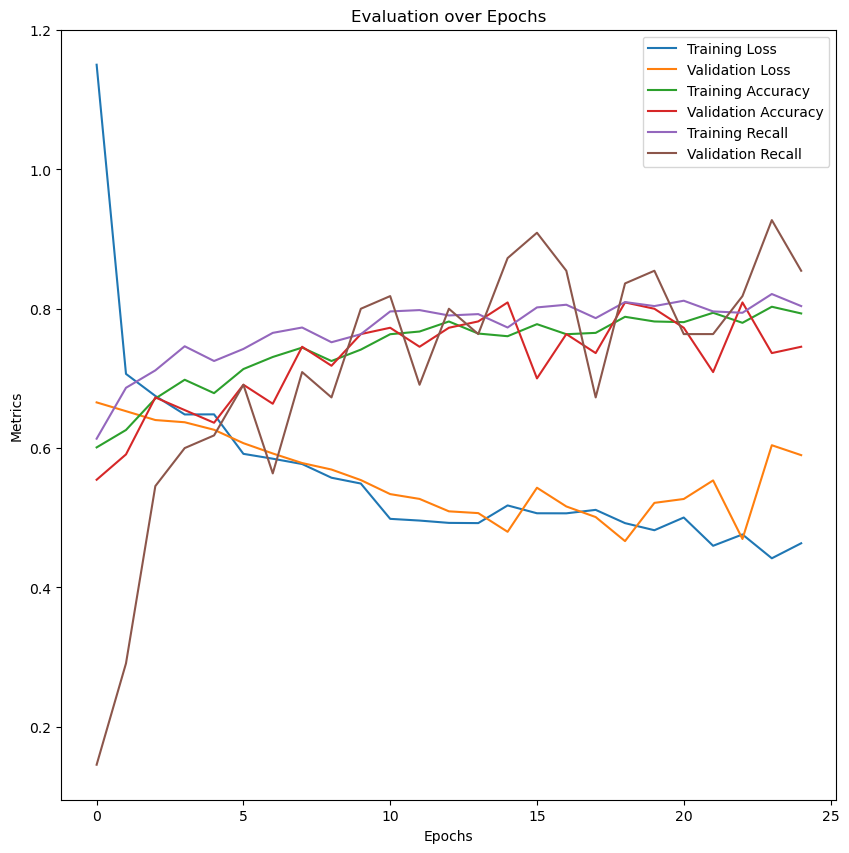

In [6]:
# plotting the training and validation metrics over epochs
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Training Loss', )
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Evaluation over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [7]:
model.save('../assets/saved_models/good_model_2')

INFO:tensorflow:Assets written to: ../assets/saved_models/good_model_2\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/good_model_2\assets


In [8]:
# feed the test dataset to the model to generate predictions
test_datagen = ImageDataGenerator(
    rescale=1./255 # This is a necessary preprocessing step
)
test_generator = test_datagen.flow_from_directory(
    '../data/test/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode=None,
    shuffle=False
)

print(test_generator.class_indices)

Found 110 images belonging to 2 classes.
{'clean': 0, 'dirty': 1}


In [9]:
# make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_class = (predictions > 0.5).astype(int)
class_labels = test_generator.classes
image_names = test_generator.filenames

# print image name and prediction
for image, pred_class in enumerate(predicted_class):
    print(f'Image {image_names[image]} predicted as class: {pred_class}')

4/4 [==============================] - 13s 2s/step
Image clean\12c943_52556a070d844543b57583b7291c93a5~mv2.jpg predicted as class: [0]
Image clean\1519ac76-9cfd-47f0-bf77-5dc3a1147adc.jpg predicted as class: [0]
Image clean\1f761525-88f0-4260-93f5-e54363e0a015.jpg predicted as class: [0]
Image clean\1fa83d4b-9b3b-4be9-abd2-fdd04c09a3e2.jpg predicted as class: [1]
Image clean\27d568c2-6951-4792-b1a8-d7f302bc7675.jpg predicted as class: [0]
Image clean\298de5fc-414c-4c7e-a023-d3651e001672.jpg predicted as class: [1]
Image clean\30799286-fc80-4789-9601-d7d9e6cc20c8.jpg predicted as class: [0]
Image clean\3325c33c-1417-4378-8068-31838ac99b3c.jpg predicted as class: [0]
Image clean\3ed7e6fc-84ec-48ec-b594-12a8f8a7cf5b.jpg predicted as class: [1]
Image clean\44765f2b-2795-4b74-ba89-94284f4f532d.jpg predicted as class: [1]
Image clean\46474608_1983203988393520_7337535301151096832_n.jpg predicted as class: [1]
Image clean\46624108_1983204011726851_8909396883701497856_n.jpg predicted as class: 

Precision score: 0.72.
Recall score: 0.87.
F1 score: 0.79.


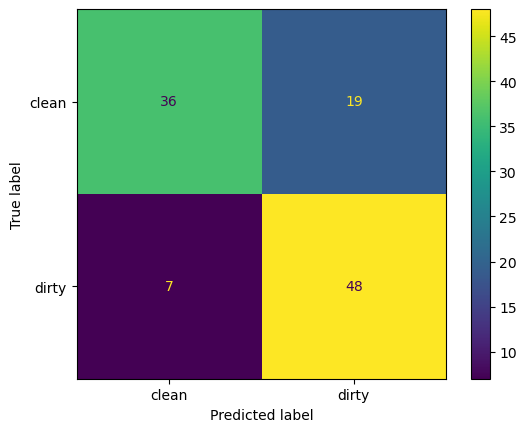

In [10]:
# evaluation metrics
precision = precision_score(class_labels, predicted_class)
recall = recall_score(class_labels, predicted_class)
f1_result = f1_score(class_labels, predicted_class)
confusing_matrix = confusion_matrix(class_labels, predicted_class)

print(f'Precision score: {round(precision, 2)}.')
print(f'Recall score: {round(recall, 2)}.')
print(f'F1 score: {round(f1_result, 2)}.')

cmd = ConfusionMatrixDisplay(confusion_matrix=confusing_matrix, display_labels=test_generator.class_indices)
cmd.plot();

In [11]:
# list of false negatives
false_negatives = []
print('False Negatives')
for image, pred_class in enumerate(predicted_class):
    if pred_class == 0:
        if pred_class != class_labels[image]:
            false_negatives.append(image_names[image])
            print(f'Image {image_names[image]} predicted class "clean" but labeled "dirty".')

False Negatives
Image dirty\12c943_6e5e6bce798c4a79bdfe21b92be8e822~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_b20de859cd0d47e397446cbbcec30f16~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\465031171_8598614230185763_4296054996684274349_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\465049001_8598614226852430_348286118249082025_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\465236596_8605904819456704_4747615728701579437_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\465453505_8605905322789987_6267472293927772884_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\84946351_2757372924309952_2201818991498887168_n.jpg predicted class "clean" but labeled "dirty".


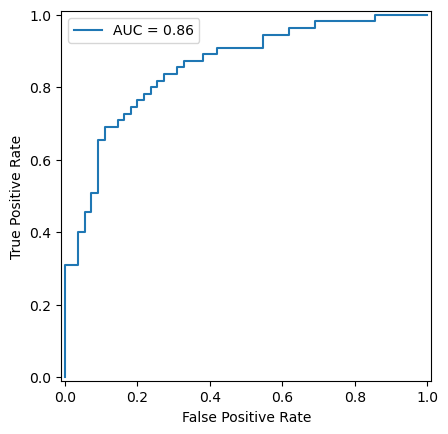

In [12]:
# Check the ROC Curve - will help us see how well the model is defining classes
fpr, tpr, thresholds = roc_curve(class_labels, predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.legend()
plt.show;

In [13]:
# generate the roc_auc_score
roc_auc_score = round(roc_auc_score(class_labels, predictions), 4)
roc_auc_score

0.8569

___
### Model Evaluation  
  

___
##### Overfitting or Underfitting
To start the model evaluation it should be noted that the validation set showed a bit more oscillation from epoch to epoch.  This can be seen in the model evaluation over epochs chart.  This is likely due to its smaller size of only 110 images.  It will be interesting to compare this observation when more data is on hand.

After taking that into account, the model can be examined for signs of overfitting and underfitting.  One of the easiest signs of overfitting to detect is a noticeable difference between training and testing accuarcy.  This model though tended to return accuracy results within 5% of each other, with an occassional result just beyond 5-7%.  Another sign that the model was not overfitting was the performance on the test set was inline with the training and validation set accuracy.  This highlights the model responding to new natural images.  Another sign of overfitting is when the validation loss function plateaus and increases while the training loss continues to fall.  This was largely not the case, though was possibly starting to show in the last few epochs.  Again, with a small validation set, it would not be surprising for the model to be too comfortable with the data.

The most obvious sign of underfitting, not performing well on training or validation accuaracy, was not the case.  The accuracy was consistently rising and outperforming a null model at 50%.  Additionally the training and validation losses were falling.  If they had plateaued early, underfiting would be a concern as the model is not learning from the data to lower the loss.  Given this is a simple model, 32 filters on one convultional layer, concern that the model is not learning complex relationships exists, and might be cornered into this simple classification task exists.  Time will tell though once more data is obtained.

Given the size of the dataset, the model architecture was kept lean to avoid overfitting to specific features.  The model will have to be adjusted should the size of th dataset increase substantially.
___
##### Predictions and Confusion Matrix

After reviewing the predictions and casting them into a confusion matrix we find a model that is ideal for this problem.  It has a strong recall, the max seen was 92.73% (with validation accuracy of 73.64%) during training.  The peak validation accuracy of 80.90% had an accompanying validation recall of 87.27%.  A justification between the two choices could be offered either way, it would depend more on the entity in the decision.  For a ship operator, getting the choice right 7 times more in a hundred would likely result in earning more vs the risk of getting it wrong few times.  Conversely, a cleaning company would look at it different.  They need to maintain the reputation of their technical knowledge, so making less mistakes (misdiagnosing something clean when it is not) would hurt more.  

True Negatives = 36 (correctly predicted clean)  
False Negatives = 7 (wrongly predicted clean)  
False Positves = 19 (wrongly predicted dirty)  
True Positives = 48 (correctly predicted dirty)  

This model's recall is strong which we can see with the smaller number of false negatives.  For further discussion, I reviewed the false negatives.  
___
##### ROC AUC Curve
The Receiver Operating Charteristic - Area Under the Curve demonstrates the model's ability to distinguish between the classes.  As mentioned earlier, 1.00 is the ideal score and 0.5 is bottom score.  A score of 0.75 would be average.  The model scored 0.86 which is above average, meaning it is distinguishing the classes fairly well.  This is also seen in the confusion matrix with more correct predictions than wrong.  This is precisely what ROC AUC measures, the true positive rate (recall) on the y-axis vs false positive rate on the x-axis.
___
##### Subjective Nature of Problem

The subjective nature of this problem should be highlighted.  This is clearly demonstrated in the false negative results.  All 7 images were 'edge cases', images I struggled with to classify.  One of which I intentionally planted to check how the model would handle it, image 84946351_2757372924309952_2201818991498887168_n.jpg.  This image appears to be of a cargo old with recently refreshed coatings.  They are bright red, with no visible scarring, nor any noticeable cargo residues.  The only aspect that could likely be concerning are the orange tank tops, but those are allowed as they tend to be addressed in cargo handling.

The other images all had features that could tilt the determination one way or the other.  One was cleaning undernearth a hatch cover on deck, a far different environment.  One had bleeding rust and scarring that would be grain clean but not hospital clean.  One had cargo stains that would be possibly grain clean but not hospital clean.

Also, the 'clean' and 'dirty' classes for this problem, are a combination of different grades of clean or dirty.  The hierarchy of cleanliness grades falls in order of:

* Hospital Clean - paint is completely intact (no scarring, flaking, tacky paint, bleeding rust, cargo stains, etc).  This is for super sensitive cargoes; soda ash, alumina, and some food products
* Grain Clean - the paint does not need to be completely intact, but must hard fast, not going to contaminate the cargo, and no previous cargo residues or loose rust.  Grains along with sulphur, potash, and other fertilizers fall into this standard.
* Water washed - typically fresh water rinsed and dried to make the holds free of cargo residues.  Less attention is given to cargo stains and rust.
* Dry sweep - no water washing and a thorough sweeping to remove cargo residues.
* Shovel clean - typically some minor cargo is left behind as the cargo unloading process cannot efficiently unload all cargo.  This is typically done when reloading the same cargo or a cargo with no cleaning standards.

With this context in mind, an image could be grain clean, but not hospital clean.
___
### More Modeling

While the results are satisfactory, they do leave some questions to explore:
* Even though the model was not showing signs of overfitting and underfitting, is the model biased to the data?
* Would selecting images with less 'distracting features' improve performance?  Increase bias?  Distracting features being people, machinery, logos, focus on details (piping, ladders, hatch covers, etc).
* Would transfer learning with a pre-trained model perform better?  Would it perform worse?  Why?

In the next notebook, we will try to answer these questions.
___